# Load dataset & preprocessing

In [1]:
import pandas as pd
import numpy as np

root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza.csv"
exp_dir = "datasets/infuluenza/vecLSTM/"

df = pd.read_csv(data_path)

/home/is/daiki-ko/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/is/daiki-ko/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df_tokyo = df[df['regnames'].isin(["Tokyo"])]

df_tokyo.head()

,Alltime,Time,region,regnames,Longitude,Latitude,Altitude,Year,Month,Week,Flucases,Holiday,Tempave,Tempmin,Tempmax,Rh
12480,12481,1,13,Tokyo,35.689185,139.691648,34.9,2000,1,1,818,2,9.528571,6.371429,13.385714,50.571429
12481,12482,2,13,Tokyo,35.689185,139.691648,34.9,2000,1,2,1167,3,8.642857,5.457143,12.000000,61.142857
12482,12483,3,13,Tokyo,35.689185,139.691648,34.9,2000,1,3,2562,2,6.828571,4.171429,9.500000,56.000000
12483,12484,4,13,Tokyo,35.689185,139.691648,34.9,2000,1,4,3781,2,5.342857,1.542857,9.400000,42.000000
12484,12485,5,13,Tokyo,35.689185,139.691648,34.9,2000,1,5,3903,2,7.214286,3.171429,11.585714,38.714286


In [3]:
train_n = int(len(df_tokyo["Flucases"])*0.75)
test_n = int(len(df_tokyo["Flucases"])*0.25)
train_n, test_n

(780, 260)

In [4]:
train_steps = np.arange(train_n)
test_steps = np.arange(train_n,train_n + test_n)

array([[<AxesSubplot:title={'center':'Flucases'}>,
        <AxesSubplot:title={'center':'Tempave'}>],
       [<AxesSubplot:title={'center':'Rh'}>,
        <AxesSubplot:title={'center':'Holiday'}>]], dtype=object)

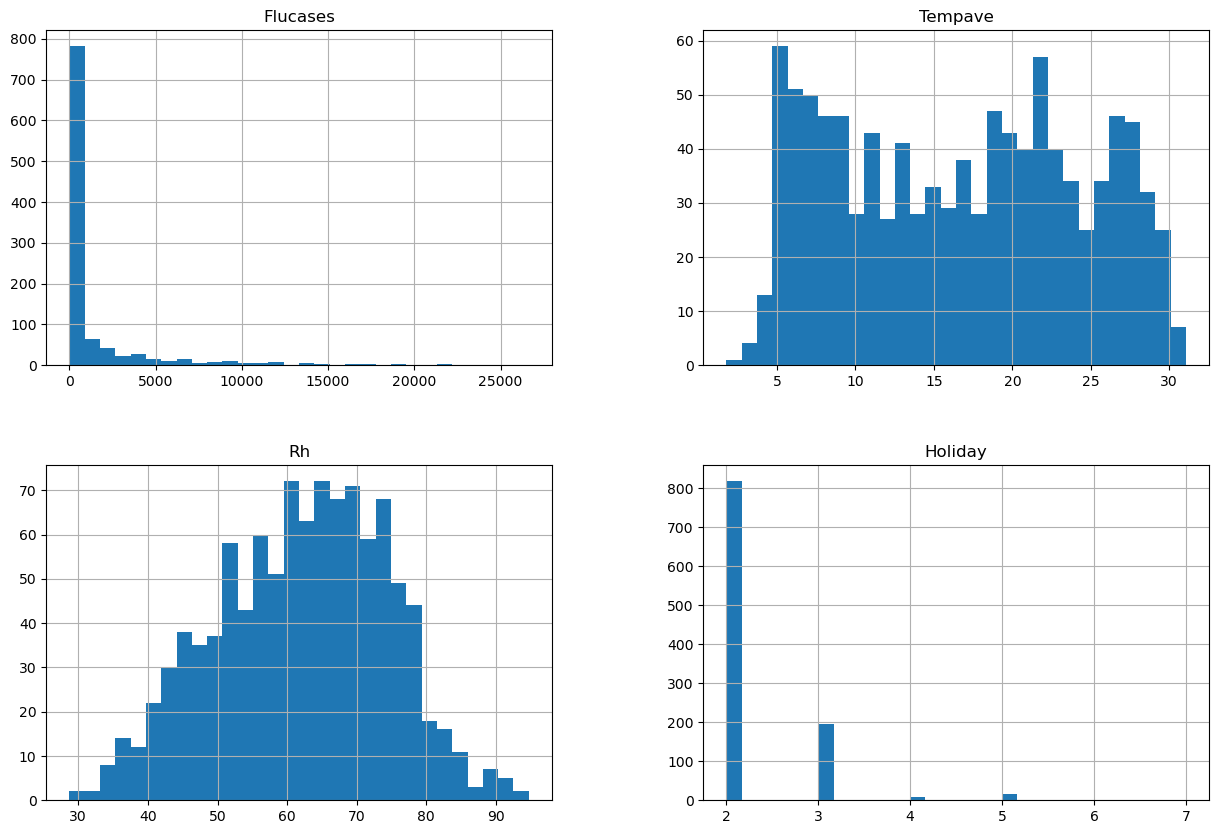

In [5]:
columns = ["Flucases","Tempave", "Rh", "Holiday"]

all_data = df_tokyo[columns]
all_data.hist(bins=30, figsize=(15, 10))

In [6]:
train_df = all_data[columns][0:train_n]
test_df = all_data[columns][train_n:train_n+test_n]

In [7]:
train_df.head()

,Flucases,Tempave,Rh,Holiday
12480,818,9.528571,50.571429,2
12481,1167,8.642857,61.142857,3
12482,2562,6.828571,56.000000,2
12483,3781,5.342857,42.000000,2
12484,3903,7.214286,38.714286,2


In [8]:
test_df.head()

,Flucases,Tempave,Rh,Holiday
13260,3809,5.357143,47.142857,3
13261,9892,6.285714,38.285714,2
13262,8198,5.628571,53.857143,3
13263,9625,6.771429,63.714286,2
13264,7844,4.228571,49.000000,2


trainとtestのdfを作る

In [9]:
train_ts_df = train_df["Flucases"]
train_ys_df = train_df[["Tempave", "Rh"]]
train_xs_df = train_df["Holiday"]

test_ts_df = test_df["Flucases"]
test_ys_df = test_df[["Tempave", "Rh"]]
test_xs_df = test_df["Holiday"]

# Dataset and DataLoader

In [10]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch
import torch.nn as nn
from torch.nn import Sequential, Linear, Tanh, Sigmoid, LeakyReLU, ReLU
import torch.nn.functional as F
import torch.optim as optim

import numpy as np #数値計算用ライブラリ
import matplotlib.pyplot as plt #描画用ライブラリ

In [11]:
root_dir = "datasets/infuluenza/"
data_path = root_dir + "Influenza.csv"
data_dir = "datasets/infuluenza/vecLSTMx/"
exp_dir = "datasets/infuluenza/vecLSTM/"

In [12]:
seq_length = 52

train_Xs = np.load(data_dir + "train_X_" + str(seq_length) + "w.npy")
train_ys = np.load(data_dir + "train_y_" + str(seq_length) + "w.npy")

In [13]:
train_Xs.shape, train_ys.shape

((728, 52, 4), (728, 1, 4))

In [14]:
import joblib

# スケーラーの読み込み
std_scaler = joblib.load(data_dir + 'std_scaler.joblib')

In [15]:
train_Xs = np.load(data_dir + "train_Xs_" + str(seq_length) + "w.npy")
train_ys = np.load(data_dir + "train_ys_" + str(seq_length) + "w.npy")
val_Xs = np.load(data_dir + "val_Xs_" + str(seq_length) + "w.npy")
val_ys = np.load(data_dir + "val_ys_" + str(seq_length) + "w.npy")

In [16]:
trn_xs_tensor = torch.Tensor(train_Xs[:,:,0:3])
trn_ys_tensor = torch.Tensor(train_ys[:,:,0:3])

val_xs_tensor = torch.Tensor(val_Xs[:,:,0:3])
val_ys_tensor = torch.Tensor(val_ys[:,:,0:3])

In [17]:
trn_xs_tensor.shape, trn_ys_tensor.shape, val_xs_tensor.shape, val_ys_tensor.shape

(torch.Size([582, 52, 3]),
 torch.Size([582, 1, 3]),
 torch.Size([146, 52, 3]),
 torch.Size([146, 1, 3]))

In [18]:
from torch.utils.data import TensorDataset, DataLoader

trn_dataset = TensorDataset(trn_xs_tensor, trn_ys_tensor)
trn_loader = DataLoader(dataset=trn_dataset,batch_size=50,shuffle=True)

val_dataset = TensorDataset(val_xs_tensor, val_ys_tensor)
val_loader = DataLoader(dataset=val_dataset,batch_size=50,shuffle=False)

In [19]:
for id, batch_data in enumerate(trn_loader):
    
    batch_x, batch_y = batch_data
    print(id, batch_x.shape, batch_y.shape)

0 torch.Size([50, 52, 3]) torch.Size([50, 1, 3])
1 torch.Size([50, 52, 3]) torch.Size([50, 1, 3])
2 torch.Size([50, 52, 3]) torch.Size([50, 1, 3])
3 torch.Size([50, 52, 3]) torch.Size([50, 1, 3])
4 torch.Size([50, 52, 3]) torch.Size([50, 1, 3])
5 torch.Size([50, 52, 3]) torch.Size([50, 1, 3])
6 torch.Size([50, 52, 3]) torch.Size([50, 1, 3])
7 torch.Size([50, 52, 3]) torch.Size([50, 1, 3])
8 torch.Size([50, 52, 3]) torch.Size([50, 1, 3])
9 torch.Size([50, 52, 3]) torch.Size([50, 1, 3])
10 torch.Size([50, 52, 3]) torch.Size([50, 1, 3])
11 torch.Size([32, 52, 3]) torch.Size([32, 1, 3])


In [20]:
for id, batch_data in enumerate(val_loader):
    
    batch_x, batch_y = batch_data
    print(id, batch_x.shape, batch_y.shape)

0 torch.Size([50, 52, 3]) torch.Size([50, 1, 3])
1 torch.Size([50, 52, 3]) torch.Size([50, 1, 3])
2 torch.Size([46, 52, 3]) torch.Size([46, 1, 3])


# LSTM model

In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size=32, output_size=1, num_layers = 2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = num_layers
        
        self.relu = ReLU()
        self.lrelu = LeakyReLU(negative_slope=0.01)
        
        # input_sizeは入力する次元数
        self.lstm = nn.LSTM(input_size=self.input_size, num_layers=self.n_layers, hidden_size=self.hidden_size, dropout=0.2)
        
        self.fc1 = nn.Linear(self.hidden_size, self.hidden_size * 4)
        self.fc2 = nn.Linear(self.hidden_size * 4, self.output_size)


    def forward(self, x):
        last_outs, hidden = self.lstm(x) #(batch_size, seq_len, hidden)
        outs = last_outs[:, -1, :] #(batch_size, hidden)
        h1 = self.relu(self.fc1(outs))
        h2 = self.fc2(h1)
        y_list = [self.relu(h2[:,0:1]), h2[:,1:3]]
        ys = torch.cat(y_list, dim=1)

        return ys

In [22]:
model = LSTM(input_size = 3, hidden_size = 32, output_size = 3, num_layers = 2)

## Prediction

In [23]:
batch_0x = list(trn_loader)[0][0]

In [24]:
batch_0x.shape

torch.Size([50, 52, 3])

In [25]:
preds = model(batch_0x)

In [26]:
preds.shape

torch.Size([50, 3])

## Train

In [27]:
model.cuda()

LSTM(
  (relu): ReLU()
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lstm): LSTM(3, 32, num_layers=2, dropout=0.2)
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

In [28]:
criterion = nn.MSELoss(reduction='none').cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [29]:
def val_model(epoch):
    
    model.eval()
    
    sum_errors = 0
    
    for batch_data in val_loader:
       
        with torch.no_grad():
            
            if torch.cuda.is_available():
                inputs, trues = batch_data
                inputs, trues = inputs.cuda(), trues.cuda()

            preds = model(inputs)
            true_ys = torch.reshape(trues[:,:,0:3], (trues.shape[0], 3))
            loss = criterion(preds, true_ys).mean(dim=0).mean()
            
            sum_errors = sum_errors + loss.data.item()

            del loss
            torch.cuda.empty_cache()
            
    return sum_errors / len(val_loader)

In [30]:
train_loss_hist = []
val_loss_hist = []
best_loss = 1e10
n_epochs = 500

for epoch in range(n_epochs):
    
    model.train()
    train_loss = 0
    
    for batch_data in trn_loader:
        
        inputs, trues = batch_data
        inputs, trues = inputs.cuda(), trues.cuda()
        
        optimizer.zero_grad()
        
        preds = model(inputs)
        true_ys = torch.reshape(trues[:,:,0:3], (trues.shape[0], 3))
        loss = criterion(preds, true_ys).mean(dim=0).mean()
        
        loss.backward() #偏微分を計算
        
        train_loss += loss.item()

        #パラメータを更新する
        optimizer.step()
    
    val_loss = val_model(epoch)
    train_loss_hist.append(train_loss / len(trn_loader))
    val_loss_hist.append(val_loss)
    
    print("epoch: ", epoch, "Train loss: ", train_loss / len(trn_loader), "Val loss: ", val_loss)
    
    if val_loss < best_loss:
        save_model_path = exp_dir + "best_model_" + str(seq_length) + "w.pt"
        torch.save(model, save_model_path)
        best_loss = val_loss

epoch:  0 Train loss:  0.9381014903386434 Val loss:  1.0165414412816365
epoch:  1 Train loss:  0.9011573120951653 Val loss:  0.9854250947634379
epoch:  2 Train loss:  0.8900585373242696 Val loss:  0.9478486776351929
epoch:  3 Train loss:  0.8308733825882276 Val loss:  0.8472416003545126
epoch:  4 Train loss:  0.6594469125072161 Val loss:  0.5606913069883982
epoch:  5 Train loss:  0.4165964325269063 Val loss:  0.37164657314618427
epoch:  6 Train loss:  0.35385293886065483 Val loss:  0.34820815920829773
epoch:  7 Train loss:  0.32645657410224277 Val loss:  0.3210774411757787
epoch:  8 Train loss:  0.30294488246242207 Val loss:  0.30012913048267365
epoch:  9 Train loss:  0.3014223513503869 Val loss:  0.2771083911259969
epoch:  10 Train loss:  0.28042775640885037 Val loss:  0.26158469915390015
epoch:  11 Train loss:  0.2647799092034499 Val loss:  0.24292168517907461
epoch:  12 Train loss:  0.2552005350589752 Val loss:  0.24184729158878326
epoch:  13 Train loss:  0.24750805149475733 Val los

epoch:  112 Train loss:  0.18537907178203264 Val loss:  0.19865089654922485
epoch:  113 Train loss:  0.18917603169878325 Val loss:  0.20089955627918243
epoch:  114 Train loss:  0.18985959266622862 Val loss:  0.19974850118160248
epoch:  115 Train loss:  0.1806946930785974 Val loss:  0.20453796287377676
epoch:  116 Train loss:  0.18954634542266527 Val loss:  0.20049947996934256
epoch:  117 Train loss:  0.18524719526370367 Val loss:  0.20452422400315604
epoch:  118 Train loss:  0.1839406155049801 Val loss:  0.20040454467137656
epoch:  119 Train loss:  0.18306618059674898 Val loss:  0.202395369609197
epoch:  120 Train loss:  0.18053724678854147 Val loss:  0.20023458202679953
epoch:  121 Train loss:  0.18329917515317598 Val loss:  0.2012567569812139
epoch:  122 Train loss:  0.18670214464267096 Val loss:  0.20021222035090128
epoch:  123 Train loss:  0.1879988219588995 Val loss:  0.2045926402012507
epoch:  124 Train loss:  0.18520198638240495 Val loss:  0.19923215607802072
epoch:  125 Train l

epoch:  224 Train loss:  0.17554446123540401 Val loss:  0.2000230352083842
epoch:  225 Train loss:  0.177392757187287 Val loss:  0.20107736190160116
epoch:  226 Train loss:  0.17435259744524956 Val loss:  0.19986490905284882
epoch:  227 Train loss:  0.17912812530994415 Val loss:  0.20217203597227731
epoch:  228 Train loss:  0.17800284052888551 Val loss:  0.1988135427236557
epoch:  229 Train loss:  0.17586511373519897 Val loss:  0.20018125077088675
epoch:  230 Train loss:  0.18023747826615968 Val loss:  0.19920697808265686
epoch:  231 Train loss:  0.1789784568051497 Val loss:  0.2006524900595347
epoch:  232 Train loss:  0.17799067248900732 Val loss:  0.19697771469751993
epoch:  233 Train loss:  0.17742193738619486 Val loss:  0.19798189401626587
epoch:  234 Train loss:  0.17599161403874555 Val loss:  0.2012802759806315
epoch:  235 Train loss:  0.1767559895912806 Val loss:  0.20102507869402567
epoch:  236 Train loss:  0.17487062638004622 Val loss:  0.19911600152651468
epoch:  237 Train lo

epoch:  336 Train loss:  0.17293484633167586 Val loss:  0.20169968406359354
epoch:  337 Train loss:  0.17486427476008734 Val loss:  0.19990335404872894
epoch:  338 Train loss:  0.17972498138745627 Val loss:  0.19938727219899496
epoch:  339 Train loss:  0.16955373995006084 Val loss:  0.19994701445102692
epoch:  340 Train loss:  0.16754159207145372 Val loss:  0.2013761649529139
epoch:  341 Train loss:  0.1769376260538896 Val loss:  0.19796611865361533
epoch:  342 Train loss:  0.16941207647323608 Val loss:  0.1999522695938746
epoch:  343 Train loss:  0.1715010702610016 Val loss:  0.20028896629810333
epoch:  344 Train loss:  0.1742840570708116 Val loss:  0.19964265823364258
epoch:  345 Train loss:  0.17309166118502617 Val loss:  0.2005366583665212
epoch:  346 Train loss:  0.16967755183577538 Val loss:  0.20106037457784018
epoch:  347 Train loss:  0.17219753935933113 Val loss:  0.20038299759229025
epoch:  348 Train loss:  0.17269261926412582 Val loss:  0.20094122489293417
epoch:  349 Train 

epoch:  448 Train loss:  0.1766671041647593 Val loss:  0.20436713099479675
epoch:  449 Train loss:  0.17149282805621624 Val loss:  0.2036592960357666
epoch:  450 Train loss:  0.17374977469444275 Val loss:  0.20622843007246652
epoch:  451 Train loss:  0.1700019190708796 Val loss:  0.20330881079037985
epoch:  452 Train loss:  0.1677368450909853 Val loss:  0.20804575085639954
epoch:  453 Train loss:  0.1701903616388639 Val loss:  0.20681889355182648
epoch:  454 Train loss:  0.1677426149447759 Val loss:  0.20654664436976114
epoch:  455 Train loss:  0.1697168822089831 Val loss:  0.204355259736379
epoch:  456 Train loss:  0.1676323345551888 Val loss:  0.2058888077735901
epoch:  457 Train loss:  0.1738252490758896 Val loss:  0.2050151377916336
epoch:  458 Train loss:  0.16643881859878698 Val loss:  0.20439556737740835
epoch:  459 Train loss:  0.1721716249982516 Val loss:  0.20429803927739462
epoch:  460 Train loss:  0.17014034216602644 Val loss:  0.20930028955141702
epoch:  461 Train loss:  0

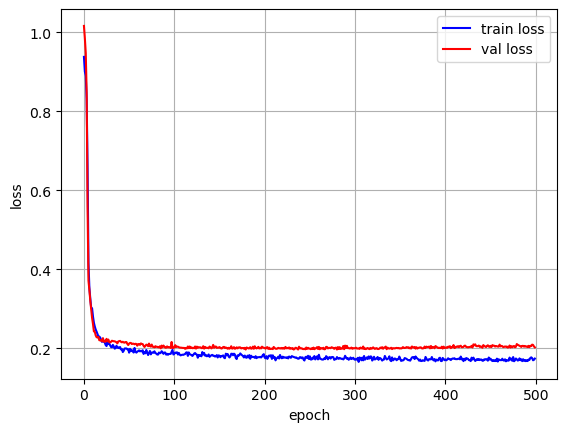

In [31]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss_hist)), train_loss_hist, c='b', label='train loss')
plt.plot(range(len(val_loss_hist)), val_loss_hist, c='r', label='val loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

In [32]:
np.argmin(val_loss_hist), np.min(val_loss_hist)

(280, 0.1968720555305481)

In [33]:
save_model_path = exp_dir + "best_model_" + str(seq_length) + "w.pt"

model = torch.load(save_model_path)

### Scatter plot

In [34]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(trn_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()

        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [35]:
np.array(trues_list).shape, np.array(preds_list).shape

((582, 1, 3), (582, 1, 3))

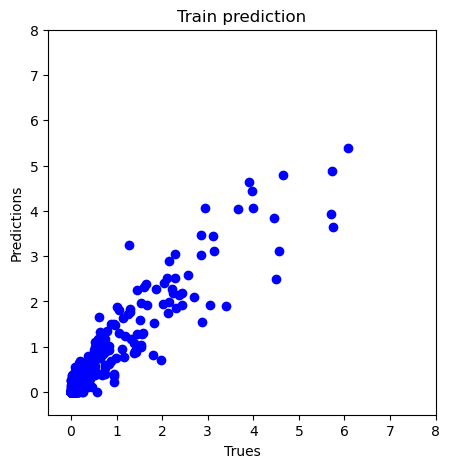

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Train prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

In [37]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(val_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()

        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145


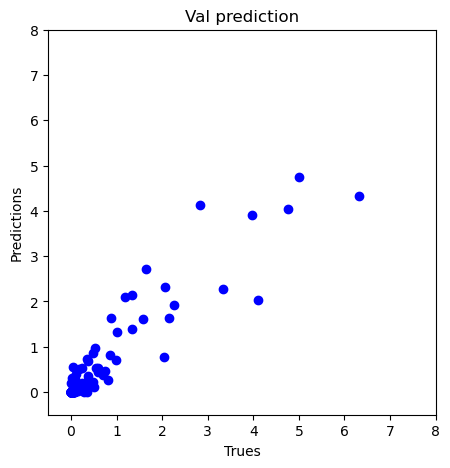

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Val prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.xlim(-0.5, 8)
plt.ylim(-0.5, 8)

plt.show()

## Test prediction

In [39]:
#test_np = np.concatenate([test_ts_np.reshape(-1,1), test_ys_np, test_xs_np.reshape(-1,1)], axis = 1)

train_np = np.load(data_dir + "train_np.npy")
test_np = np.load(data_dir + "test_np.npy")

In [40]:
train_np.shape, test_np.shape

((780, 4), (260, 4))

In [41]:
#元のデータの最大値と最小値を指定
dat_min = 0
dat_max = 3e5

#スケール後の最大値と最小値を指定
custom_min = 0
custom_max = 100

test_scaled_ts = (np.array(test_np[:,0]) - dat_min) / (dat_max - dat_min) * (custom_max - custom_min) + custom_min

In [42]:
test_scaled_ys = std_scaler.transform(test_np[:,1:3])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [43]:
test_scaled_ys.shape, test_scaled_ts.reshape(-1,1).shape, test_np[:,-1].shape

((260, 2), (260, 1), (260,))

In [44]:
test_all_np = np.concatenate([test_scaled_ts.reshape(-1,1), test_scaled_ys, test_np[:,-1].reshape(-1,1)], axis = 1)

In [45]:
test_all_np.shape

(260, 4)

In [46]:
test_np[:,-1].shape, test_scaled_ts.shape, test_scaled_ys.shape, test_np.shape

((260,), (260,), (260, 2), (260, 4))

### 1. Prediction based on results from 40 days ago

In [47]:
from typing import Tuple

def make_sequence_data(data: np.ndarray, seq_size: int) -> Tuple[np.ndarray, np.ndarray]:
    
    """データをsequence_sizeに指定したサイズのシーケンスに分けてシーケンスとその答えをarrayで返す
    Args:
        data (np.ndarray): 入力データ
        seq_size (int): シーケンスサイズ
    Returns:
        seq_arr: seq_sizeに指定した数のシーケンスを格納するarray
        target_arr: シーケンスに対応する答えを格納するarray
    """

    num_data = len(data)
    seq_data = []
    target_data = []
    
    for i in range(num_data - seq_size):
        seq_data.append(data[i:i+seq_size])
        target_data.append(data[i+seq_size:i+seq_size+1])
        
    seq_arr = np.array(seq_data)
    target_arr = np.array(target_data)

    return seq_arr, target_arr

In [48]:
test_Xs, test_ys = make_sequence_data(test_all_np, seq_length)

In [49]:
test_Xs.shape, test_ys.shape

((208, 52, 4), (208, 1, 4))

In [50]:
tst_xs_tensor = torch.Tensor(test_Xs[:,:,0:3])
tst_ys_tensor = torch.Tensor(test_ys[:,:,0:3])

In [51]:
from torch.utils.data import TensorDataset, DataLoader

tst_dataset = TensorDataset(tst_xs_tensor, tst_ys_tensor)

In [52]:
preds_list = []
trues_list = []

model.eval()
with torch.no_grad(): # 勾配計算の無効化
    for id, data in enumerate(tst_dataset):
        inputs, trues = data
        inputs, trues = inputs.cuda(), trues.cuda()

        inputs = torch.reshape(inputs, (1, seq_length, inputs.shape[-1]))
        preds = model(inputs)
        true_y = trues.reshape(preds.shape)
        
        print(id)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
        trues_list.append(true_y.to('cpu').detach().numpy().copy())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207


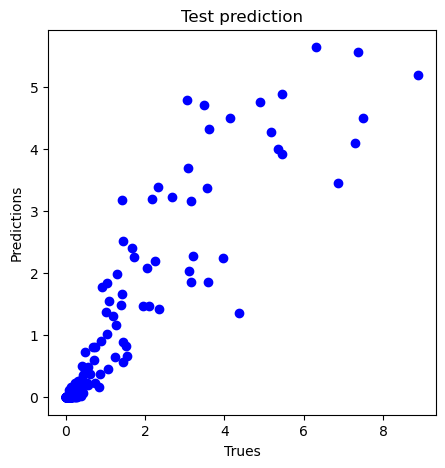

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0], c = "b") # 散布図を描画
plt.title("Test prediction")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [54]:
tst_trues, tst_preds = np.array(trues_list)[:,:,0], np.array(preds_list)[:,:,0]

In [55]:
tst_preds = (np.array(preds_list)[:,:,0] - custom_min) / (custom_max - custom_min) * (dat_max - dat_min) + dat_min

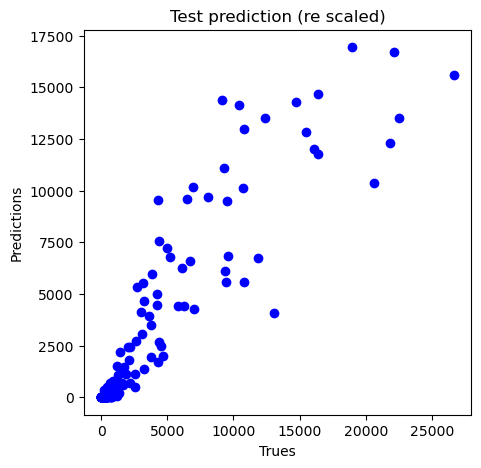

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(test_np[seq_length:,0], tst_preds, c = "b") # 散布図を描画
plt.title("Test prediction (re scaled)")
plt.xlabel("Trues")
plt.ylabel("Predictions")
# y=x の対角線を追加
#plt.plot([-2.0, 3.5], [-2.0, 3.5], 'r--')  # 赤の破線で対角線を描画

plt.show()

In [57]:
tst_preds.shape

(208, 1)

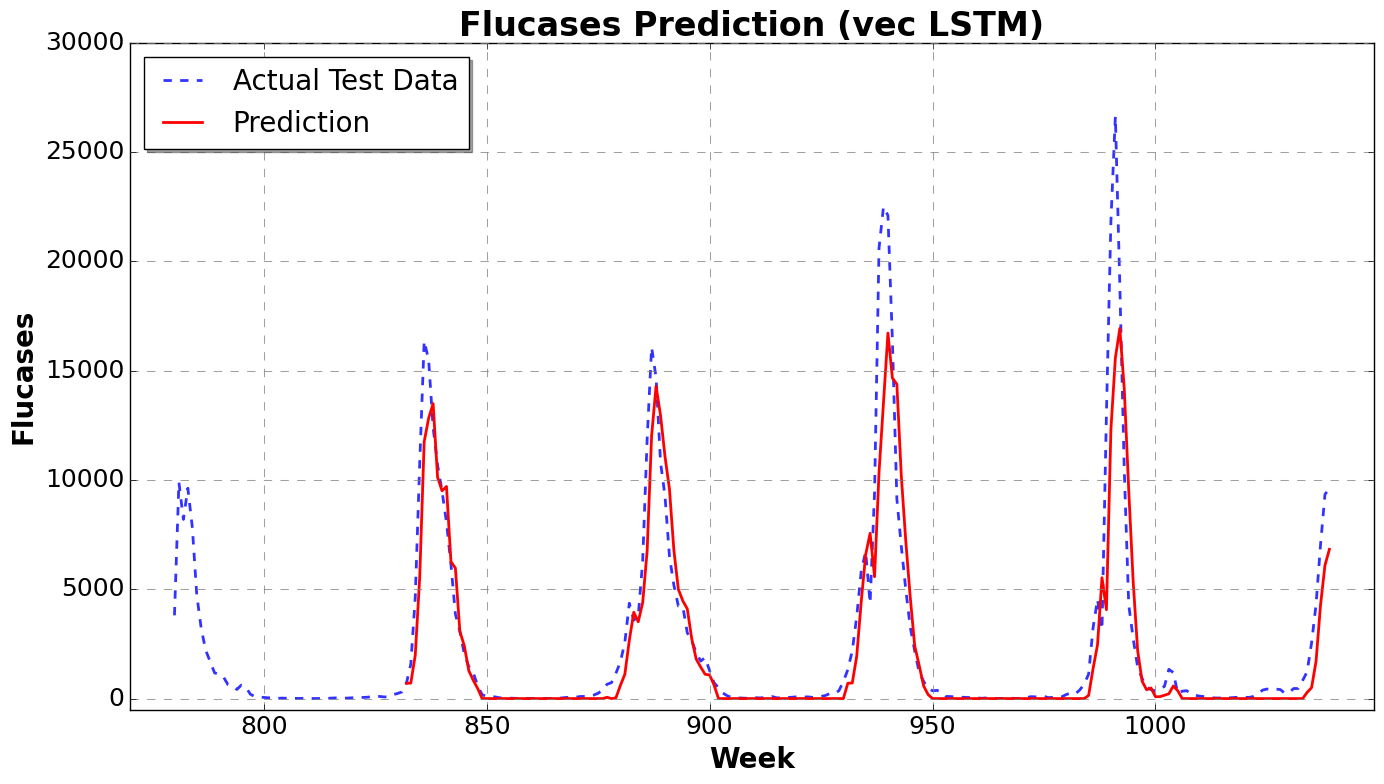

In [58]:
plt.figure(figsize=(14, 8))
plt.style.use('classic')  # スタイリッシュな背景に変更

# 実際のデータと予測データをプロット
plt.plot(test_steps, df_tokyo["Flucases"][train_n:train_n+test_n], label="Actual Test Data", linestyle='--', linewidth=2, color='blue', alpha=0.8)
plt.plot(test_steps[seq_length:], tst_preds, label="Prediction", linestyle='-', linewidth=2, color='red', alpha=1.0)

# 軸ラベルとタイトルを追加
plt.xlabel("Week", fontsize=20, fontweight='bold')
plt.ylabel("Flucases", fontsize=20, fontweight='bold')
plt.title("Flucases Prediction (vec LSTM)", fontsize=24, fontweight='bold')

# グリッドの調整
plt.grid(color='gray', linestyle='--', linewidth=0.75, alpha=0.75)

# 目盛りのフォントサイズを変更
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# 凡例の調整
plt.legend(fontsize=20, loc='upper left', frameon=True, shadow=True)
plt.ylim(bottom=-500)
plt.xlim(left=min(test_steps) - 10, right = max(test_steps) + 10)

# 仕上げ
plt.tight_layout()
#plt.savefig("Flucases Prediction (vec LSTM).jpg", dpi=200, bbox_inches='tight', format='jpg')
plt.show()

In [59]:
from sklearn.metrics import (
    mean_squared_error,  # MSE
    mean_absolute_error,  # MAE
    r2_score, # R2
)

from scipy.stats import pearsonr

def reg_metric(trues, preds, name):
    mse = mean_squared_error(trues, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(trues, preds)
    r2 = r2_score(trues, preds)
    r, p = pearsonr(trues, preds)
    
    print(name)
    print(f'MSE : {mse}.')
    print(f'RMSE : {rmse}.')
    print(f'MAE : {mae}.')
    print(f'R2 : {r2}.')
    print("pearson :", r, p)

In [60]:
reg_metric(test_np[seq_length:,0], tst_preds[:,0], "Flucases")

Flucases
MSE : 4096997.4352856646.
RMSE : 2024.1041068298994.
MAE : 916.1914353737465.
R2 : 0.8300937672094866.
pearson : 0.9210624190050014 2.5399357827836626e-86
